# KKBox Customer Lifetime Value Analysis

---

# Part 2: <font color=green>*Survival, Hazard, and LTV Analysis*</font>

---

In [2]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import datetime 

# Imports for CLV
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

## Import and Prep Data

In [3]:
# Import Transaction Files
CLV_Feb2016 = pd.read_csv('D:/J-5 Local/CLV_Feb2017.csv')

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
CLV_Feb2016[['tenure','is_churn']].to_csv('Tenure-Churn Data')

## 1) Survival Analysis

With the help of Survival Analysis we can focus on churn prevention efforts of high-value customers with low survival time. This analysis also helps us to calculate Customer Life Time Value. In this use case, Event is defined as the time at which the customer churns / unsubscribe. Time of origin is defined as the time at which the customer starts the service/subscription with a company. Time scale could be months, or weeks. The difference between the time of event and the time origin gives us the time to event.

### <font color=purple>Overall Population</font>

First we will take an overall observation of all users to get the big picture of what is the underlying behavior. 

In [5]:
## Time to event data of censored and event data
T = CLV_Feb2016['tenure']

## It has the churned (1) and censored is (0)
E = CLV_Feb2016['is_churn']

## create a kmf object as km
kmf = KaplanMeierFitter() ## instantiate the class to create an object

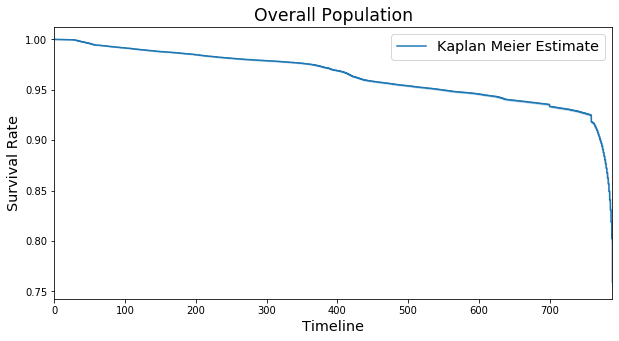

In [6]:
## Fit the data into the model
kmf.fit(T, E, label='Kaplan Meier Estimate')

## Create an estimate
plt.figure(figsize=(10,5))
kmf.plot()

# Plot Details
plt.title('Overall Population', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline', fontsize='x-large')
plt.legend(fontsize='x-large')

***Notice the drop who are those people.***

Overall retention seems pretty strong with ***> 95%*** probability of retaining users past 400 days. **We do observe a drop off but I don't know why that is present.** Overall it looks like KKBox is quite a healthy business as the odds of a customer surviving are high. Let's break up our data into various cohorts to develop a solid foundation before determining Lifetime Value for our customers.

### <font color=purple>Survival Analysis #1 - Clusters</font>

We begin right where we left off in our customer segmentation analysis. In the previous project we identified 4 different cohorts based on user activity. They were as follows: 

***Cluster 3, The Power Users***

Small in numbers but Loyal, this segment of users was the most active across all metrics. As these users tend to have longer membership lengths than the others, their proportional churn was below 1%. This group also had the highest average revenue per user. 

***Cluster 2, Secondary Power Users***

In terms of activity, these users were a close second to our Power Users and contributed to roughly ~16% of the total observed revenue. Like our Cluster 0 users, they have a churn % sitting slightly above 1%. 

***Cluster 0, The Active Majority***

Coming in at third, in terms of activity, we have what we call 'The Active Majority'. Making up nearly 43% of our observed population these users are the strongest contributors to revenue making up 43% of total revenue. Although Cluster 2 users were more active, there was virtually no difference between them in terms of Churn % and Average Revenue Per User.

***Cluster 1, The Inactive Minority***

With the largest amount of churn compared to all other groups, we observed how this segment of customers is significantly less active than the rest of the other groups. What was interesting however was that these users were most likely to have received discounts on their subscriptions and yet many of them ended up churning. Even as we just saw in the previous section: ***34.5% of all users in Cluster 1 who currently underpaid their plan price, churned.*** This makes me question whether or not many of these people are even worth spending resources on and reinforces why Customer Lifetime Value is so important when determining who is worth going after.

I wish we had more data related to user demographics and how these users were acquired so we can have a better understanding of attribution. Given the current, and limited, dataset we were able to make strides on creating an initial customer segmentation model. In the next project, we will work on understanding Customer Lifetime Value and how it relates to these segments.

In [7]:
# Distribution of Clusters
CLV_Feb2016['Cluster'].value_counts()

KeyError: 'Cluster'

#### **Kaplan Curve for**: *Cluster Cohorts*

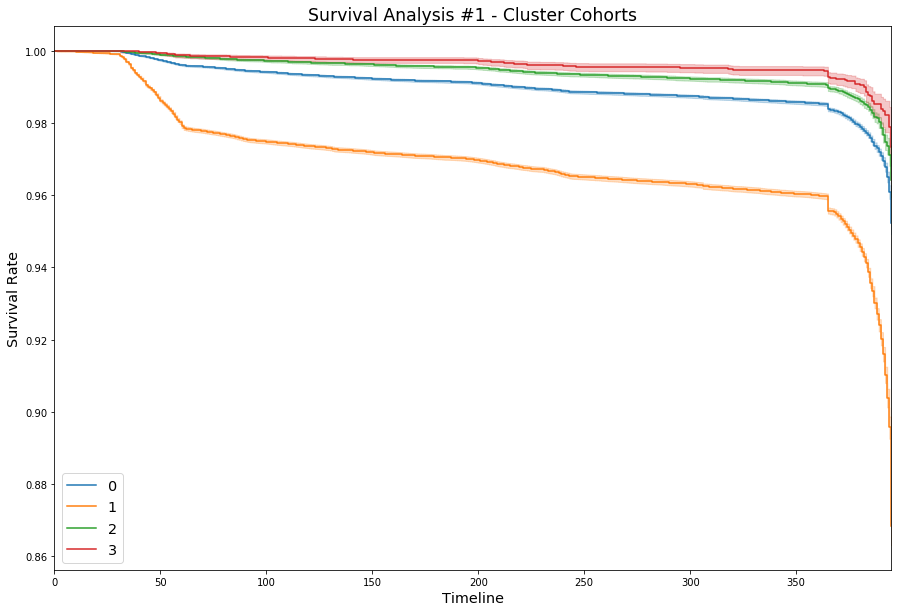

In [7]:
## Create the cohorts from the 'Cluster' column
plt.figure(figsize=(15,10))
ax = plt.subplot()
for c in np.unique(CLV_Feb2016['Cluster']):
    x = (CLV_Feb2016['Cluster'] == c)
    kmf.fit(T[x], E[x], label=c)
    kmf.plot(ax=ax)

# Plot Details
plt.title('Survival Analysis #1 - Cluster Cohorts', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

We see a clearly seperation between the *Inactive Minority* and the result of the cohorts. This is a solid follow up to the segmentation analysis, validating the results.

### <font color=purple>Survival Analysis #2 - Registration Method</font>

Although KKBox doesn't give much information on Registration Method, I find it to be an interesting feature as it could potentially represent how the user was onborded. If true, such a feature would be essential in identifying the sources that provide the most valuable users.

In [8]:
# Distribution of # of Unique payment plans
CLV_Feb2016['registered_via'].value_counts()

7     482726
9     236620
3     105445
4      49283
13      3087
Name: registered_via, dtype: int64

According to the data there are only 5 different Registration Methods.

#### **Kaplan Curve for**: *Registration Method*

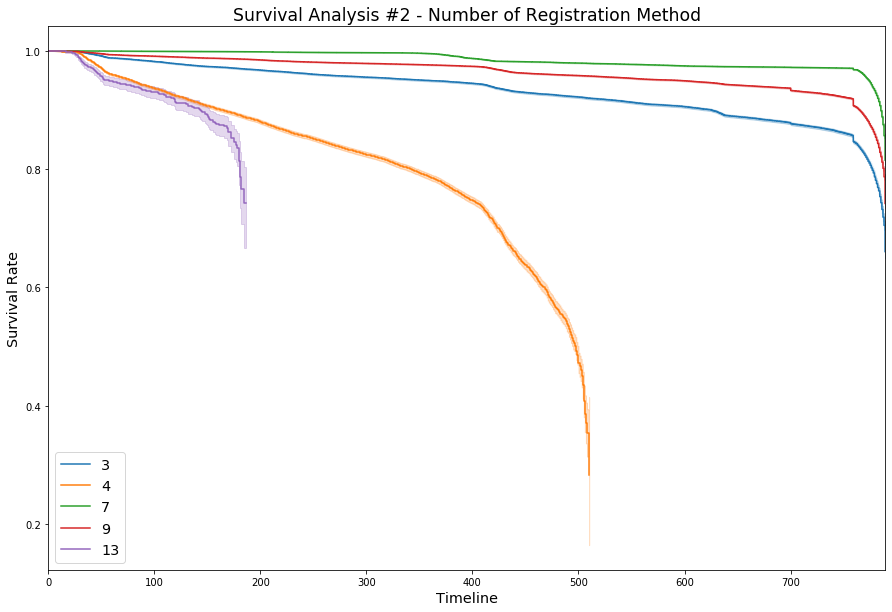

In [9]:
## Create the cohorts from the 'registered_via' column
plt.figure(figsize=(15,10))
ax = plt.subplot()
for c in np.unique(CLV_Feb2016['registered_via']):
    x = (CLV_Feb2016['registered_via'] == c)
    kmf.fit(T[x], E[x], label=c)
    kmf.plot(ax=ax)

# Plot Details
plt.title('Survival Analysis #2 - Number of Registration Method', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

Rethinking and understanding why #4 is performing bad.
Redistributing funds over different methods, however this depends on channel cost.
We never leave customers, why are they perfroming so poorly. Understand what this method is leading

This is VERY interesting. Here we see a clear difference in survival rate over all four registration methods, with 7, 9, and 3 outperforming 4. If our assumption of this feature is true, then through attribution we could exclusively invest in the former 3 methods to acquire optimal valued members.

### <font color=purple>Survival Analysis #3 - Number of Unique Payment Plans</font>

For our first cohort we will look into the differences between members and the # of unique payment plans they have had

In [10]:
# Distribution of # of Unique payment plans
CLV_Feb2016['unique_payment_plans'].value_counts()

1    521438
2    335244
3     18167
4      2029
5       235
6        41
7         6
8         1
Name: unique_payment_plans, dtype: int64

Looking at these values we see that Members with only 1 single plan throughout their lifetime are the overwhelming majority making up roughly 95% of the population.

#### **Kaplan Curve for**: *Number of Unique Payment Plans*

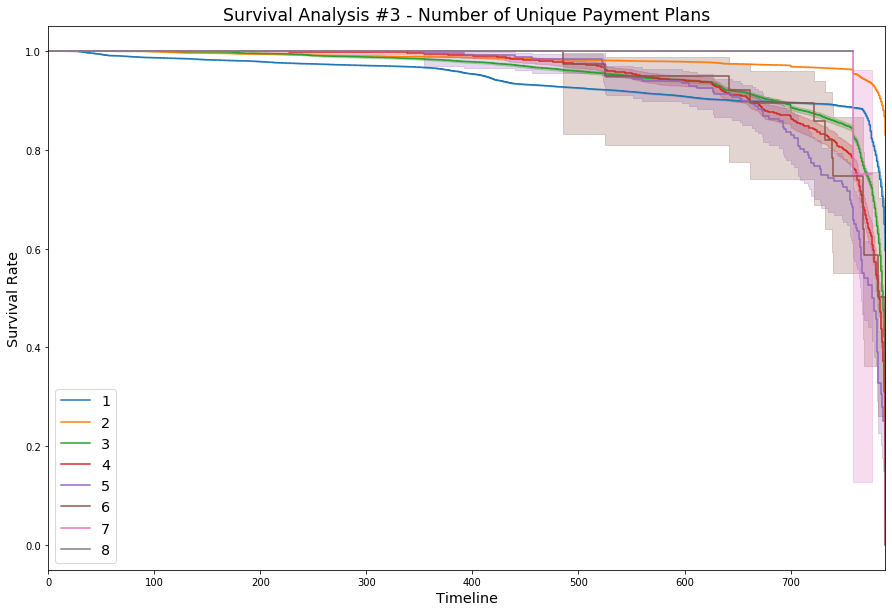

In [11]:
## Create the cohorts from the 'unique_payment_plans' column
plt.figure(figsize=(15,10))
ax = plt.subplot()
for c in np.unique(CLV_Feb2016['unique_payment_plans']):
    x = (CLV_Feb2016['unique_payment_plans'] == c)
    kmf.fit(T[x], E[x], label=c)
    kmf.plot(ax=ax)

# Plot Details
plt.title('Survival Analysis #3 - Number of Unique Payment Plans', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline', fontsize='x-large')
plt.legend(fontsize='x-large')

Members with a single payment plan over their lifetime were more likely to churn compared to members who had 2 or more plans. However, this difference doesn't really seem to be a significant. Let's take a deeper look at which plans are associated with a lower survival rate for users who have a single plan.

### <font color=purple>Survival Analysis #4 - Payment Plan Durations for Members with a Single Plan</font>

For our first cohort we will look into the differences between members and the # of unique payment plans they have had

In [12]:
# Distribution of Payment Plan Durations
plan_duration = CLV_Feb2016[CLV_Feb2016['unique_payment_plans'] == 1]['payment_plan_days'].value_counts().reset_index()
plan_duration.columns = ['plan_duration','amount']
plan_duration.head(10)

,plan_duration,amount
0,30.0,511191
1,410.0,3940
2,195.0,1551
3,180.0,1378
4,120.0,661
5,395.0,543
6,7.0,501
7,100.0,347
8,60.0,254
9,240.0,223


Month-to-Month is the most popular with other durations making up a just small fraction of the population. The durations themselves do not show any consistent pattern with respect to progression in duration length and thus seem a bit random. Lets take a look at a representative sample of the top 10 plan durations

#### **Kaplan Curve for**: *Payment Plan Durations for Members with a Single Plan*

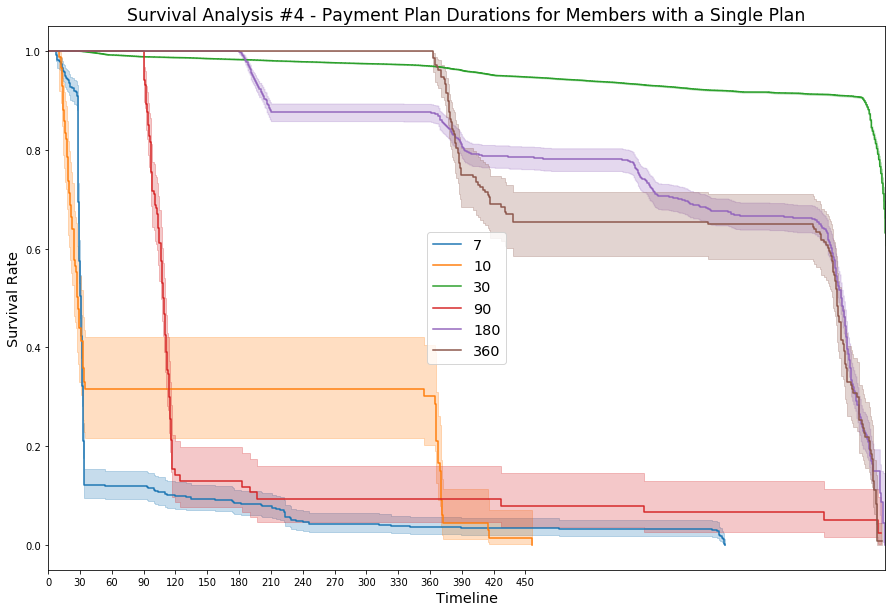

In [13]:
# Filter df to singple payment plan users, create temp variables for Tenure and Churn
temp = CLV_Feb2016[CLV_Feb2016['unique_payment_plans'] == 1]
T_temp = temp['tenure']
E_temp = temp['is_churn']

## Create the cohorts from the 'unique_payment_plans' column
plt.figure(figsize=(15,10))
ax = plt.subplot()
for c in [7,10,30,90,180,360]:
    x = (temp['payment_plan_days'] == c)
    kmf.fit(T_temp[x], E_temp[x], label=c)
    kmf.plot(ax=ax)

# Plot Details
plt.title('Survival Analysis #4 - Payment Plan Durations for Members with a Single Plan', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline', fontsize='x-large')
plt.xticks(np.arange(0,460,30))
plt.legend(fontsize='x-large')

Some observations:
Notice how over time, on every 30 day interval except for the beginning, Survival rate seams to hold well. In contrast, the larger Plan Durations have significant drop offs after each of their respective intervals. Members with a 180 day plan are a perfect example of this as once their plan expires their survival rate plummets. This makes me believe that once their plan expires, people with large plan durations are less willing to resubscribe at the same High, bundled rate. These users immediately churn with out consideration of other plans.


### <font color=purple>Survival Analysis #5 - Discount Received</font>

For our first cohort we will look into the differences between members and the # of unique payment plans they have had

In [14]:
# Distribution of Payment Plan Durations
CLV_Feb2016['discount'].value_counts()

No Discount    815936
Discount        61225
Name: discount, dtype: int64

Month-to-Month is the most popular with other durations making up a just small fraction of the population. The durations themselves do not show any consistent pattern with respect to progression in duration length and thus seem a bit random. Lets take a look at a representative sample of the top 10 plan durations

#### **Kaplan Curve for**: *Discount Received*

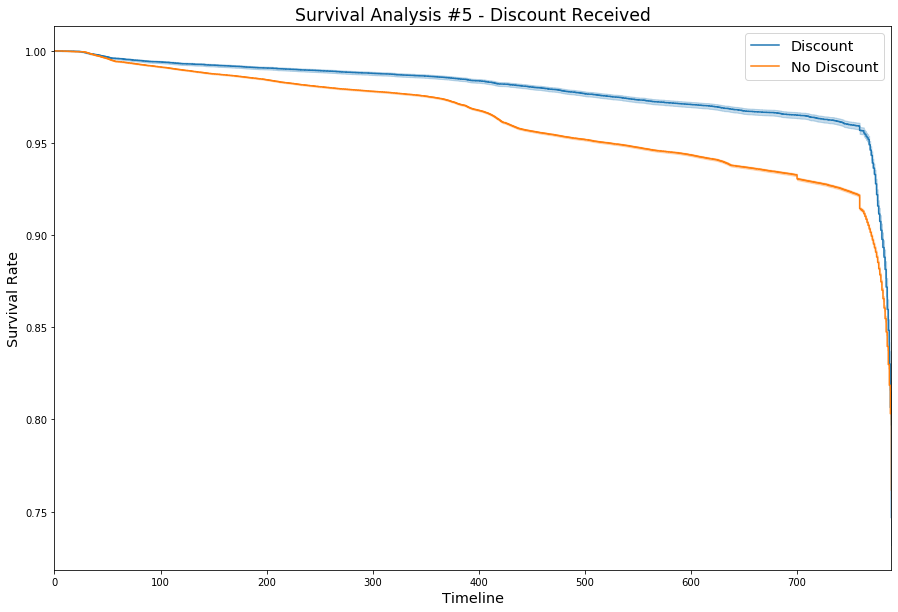

In [16]:
## Create the cohorts from the 'discount' column
plt.figure(figsize=(15,10))
ax = plt.subplot()
for c in np.unique(CLV_Feb2016['discount']):
    x = (CLV_Feb2016['discount'] == c)
    kmf.fit(T[x], E[x], label=c)
    kmf.plot(ax=ax)

# Plot Details
plt.title('Survival Analysis #5 - Discount Received', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline', fontsize='x-large')
plt.legend(fontsize='x-large')

As expected, members who have recieved a discount are more likely to have a lower suvival rate.

## 2) Cox Proportional Hazard Model (Survival Regression)

### - <font color=blue>Data Pre-Processing</font> -

In [25]:
# Specify the Continuous and Categorical features we will include in our regression model
cont_feat = ['tenure','unique_payment_plans']
cat_feat = ['registered_via','discount']

# Create df for regression model
CLV_Feb2016_Cox = CLV_Feb2016[['is_churn'] + cont_feat + cat_feat]

# Encode Categoricals
CLV_Feb2016_Cox = pd.get_dummies(data=CLV_Feb2016_Cox, columns=cat_feat, prefix_sep='_',drop_first=True)

# Use PCA to make 1 component for 'registered_via' to prevent multicolinearity errors
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
CLV_Feb2016_Cox['registered_via_PCA'] = pca.fit_transform(CLV_Feb2016_Cox[['registered_via_4','registered_via_7','registered_via_9','registered_via_13']])

CLV_Feb2016_Cox = CLV_Feb2016_Cox.drop(['registered_via_4','registered_via_7','registered_via_9','registered_via_13'], axis=1)

### - <font color=blue>Build CPH Regression Model</font> -

In [29]:
# Instantiate a cph object
cph = CoxPHFitter()   

# Fit the data to train the model
model = cph.fit_right_censoring(CLV_Feb2016_Cox, duration_col='tenure', event_col='is_churn')

In [34]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons
wbf = WeibullFitter()
wbf.fit(CLV_Feb2016_Cox['tenure'], CLV_Feb2016_Cox['is_churn'])
wbf.plot()

ValueError: This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.

### - <font color=blue>Evaluate Model</font> -

In [28]:
# show model summary
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
unique_payment_plans,-0.744402,0.475018,0.008704,-0.761461,-0.727342,0.466983,0.483192,-85.523440,0.000000e+00,inf
discount_No Discount,0.193144,1.213057,0.017109,0.159612,0.226676,1.173056,1.254423,11.289354,1.481220e-29,95.769128
registered_via_PCA,0.712008,2.038080,0.006842,0.698598,0.725419,2.010931,2.065596,104.060375,0.000000e+00,inf


The summary statistics above indicates the significance of the covariates in predicting the churn risk. Gender doesn’t play any significant role in predicting the churn, whereas all the other covariates are significant.

Interpreting the summary

- The hazard ratio (HR) given under exp(coef) against each predictor shows that MonthlyCharges feature with exp(coef) = 1.0 has no effect on the hazard

- Partner_Yes feature with exp(coef) = 0.53 (i.e., less than 1) which means a decrease in hazard and hence better survival. So, having a partner reduces the hazard by a factor of 0.53 and hence if a customer has a partner, it’s a good prognostic for better survival

- Looking at the p-values of the predictors make it clear that the predictors Partner_Yes, contract_type_two_years and contract_type_yearly are significant (as p-values are < 0.05 at 5% Level of significance thereby not accepting the null hypothesis of the CPH model that all the predictors have zero significance) and MonthlyCharges, gender_Male are insignificant (as their p-values are >0.05)

- Interesting point to note here is that , the β (coef ) values in case of covariates MonthlyCharges and gender_Male is approximately zero (~-0.01), but still the MonthlyCharges plays a significant role in predicting churn , while the latter is insignificant. The reason is that the MonthlyCharges is continuous value and it can vary from the order of tens, hundreds to thousands, when multiplied by the small coef (β=-0.01), it becomes significant. On the other hand, the covariate gender can only take the value 0 or 1, and in both the cases [exp(-0.01 * 0), exp(-0.01*1)] it will be insignificant.

### - <font color=blue>Calculate and Evaluate LT and LTV</font> -

In [31]:
# Make new column for LT and LTV
CLV_Feb2016['LT'] = model.predict_expectation(CLV_Feb2016_Cox)
CLV_Feb2016['LTV'] = CLV_Feb2016['LT'] * CLV_Feb2016['avg_paid_per_day'] 

In [ ]:
distribution and histogram of each or something, refer to fader's excel white paper

Text(0.5, 1.0, 'Distribution of Observed Tenure')

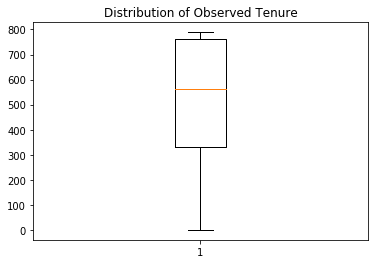

In [38]:
plt.boxplot(CLV_Feb2016['tenure'])
plt.title('Distribution of Observed Tenure')

Text(0.5, 1.0, 'Distribution of Expected Lifetime')

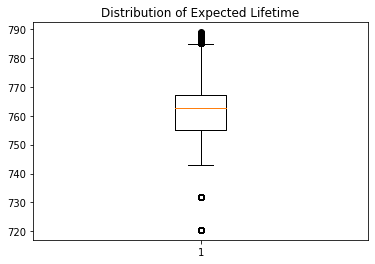

In [37]:
plt.boxplot(CLV_Feb2016['LT'])
plt.title('Distribution of Expected Lifetime')

### - <font color=blue>Re-evaluate High Risk Users</font> -

In [ ]:
plt.boxplot(expected_lifetime)

In [ ]:
model.plot()